We have 2 types of models. 

1. n concrete variables that each select a gene
2. A concrete variable for each gene that chooses to select/not select each gene

Case 1 is more interpretable for our setting because we don't need a liner layer to force the model to select "n_select" number of genes.

Using the full set of genes (550) as input makes it hard for the concrete variables to learn which features/genes to select.

Models trained on a subset of total genes vs full genes seem to have overlapping "selected genes".

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from graphFeatureSelect.utils import get_adata
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv, GCNConv
from torch_geometric.utils import add_remaining_self_loops

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.5, rc=custom_params)
%config InlineBackend.figure_format="retina"

In [124]:
def train_gnn_concrete(model, optimizer, data, criterion, temp):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index, temp)  # Perform a single forward pass.
    loss = criterion(
        out[data.train_mask], data.y[data.train_mask]
    )  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def val_gnn_concrete(model, data):
    model.eval()
    temp = 0.01
    out = model(data.x, data.edge_index, temp)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    return val_acc


def test_gnn_concrete(model, data):
    model.eval()
    temp = 0.01
    out = model(data.x, data.edge_index, temp)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

In [125]:
class GATnet_concrete(torch.nn.Module):
    def __init__(self, n_mask, hidden_channels, num_features, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATv2Conv(num_features, hidden_channels)
        self.conv2 = GATv2Conv(hidden_channels, num_classes)
        self.n_mask = n_mask
        self.num_features = num_features
        self.num_classes = num_classes
        self.concrete = nn.Parameter(torch.randn(self.n_mask, self.num_features))

    def forward(self, x, edge_index, temp):
        mask = F.gumbel_softmax(self.concrete, tau=temp, hard=True)
        mask = torch.sum(mask, axis=0)
        mask = torch.clamp(mask, min=0, max=1)
        x = mask * x
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def softmax(self):
        return F.softmax(self.concrete, dim=1)


# model 2 doesn't have a restriction on how many genes to select
class GATnet_concrete_2(torch.nn.Module):
    def __init__(self, n_mask, hidden_channels, num_features, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATv2Conv(num_features, hidden_channels)
        self.conv2 = GATv2Conv(hidden_channels, num_classes)
        self.n_mask = n_mask
        self.num_features = num_features
        self.num_classes = num_classes
        self.concrete = nn.Parameter(torch.randn(self.n_mask, 2))  # input_gene_cnt x 2 == num_features x 2

    def forward(self, x, edge_index, temp):
        mask = F.gumbel_softmax(self.concrete, tau=temp, hard=True)
        mask = mask[:, 0]  # 0th index denotes if gene is "selected" as a feature. shape = [input_gene_cnt]

        x = mask * x
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def softmax(self):
        return F.softmax(self.concrete, dim=1)


class GATnet_concrete_3(torch.nn.Module):
    def __init__(self, n_mask, n_select, hidden_channels, num_features, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.n_mask = n_mask
        self.num_features = num_features
        self.num_classes = num_classes
        self.n_select = n_select
        self.conv1 = GATv2Conv(self.n_select, hidden_channels)
        self.conv2 = GATv2Conv(hidden_channels, num_classes)
        self.concrete = nn.Parameter(torch.randn(self.n_mask, 2))  # input_gene_cnt x 2 == num_features x 2
        self.lin_1 = nn.Linear(self.n_mask, self.n_select)

    def forward(self, x, edge_index, temp):
        mask = F.gumbel_softmax(self.concrete, tau=temp, hard=True)
        mask = mask[:, 0]  # 0th index denotes if gene is "selected" as a feature. shape = [input_gene_cnt]

        x = mask * x  # some genes zeroed out
        x = self.lin_1(
            x
        )  # linear layer forces model to select nonzero genes (?) and with self.n_select we can force it to choose n_select genes (backpropagates to concrete variable)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def softmax(self):
        return F.softmax(self.concrete, dim=1)

In [126]:
def linear_temp_schedule(epoch):
    return 10 * (1 - epoch / 1000) + 1e-3


def exp_decay_temp_schedule(epoch, total_epoch):
    start_temp = 10
    end_temp = 0.01
    temp = start_temp * (end_temp / start_temp) ** (epoch / total_epoch)
    return temp


# Article from Ian Covert says using temp = 0.1 throughout training is effective as well.

In [127]:
def training_loop(model, data, total_epoch):
    optimizer_self = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    loss_list = []
    for epoch in range(1, total_epoch + 1):
        loss = train_gnn_concrete(model, optimizer_self, data, criterion, exp_decay_temp_schedule(epoch, total_epoch))
        val_acc = test_gnn_concrete(model, data)
        if epoch % 200 == 0:
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val acc: {val_acc:.4f}")
        loss_list.append(loss.detach().numpy())
    model.eval()
    val_acc = test_gnn_concrete(model, data)
    print(f"Model accuracy: {val_acc:.4f}")
    return val_acc, loss_list

In [128]:
adata = get_adata()

/data/users1/dkim195/miniconda3/envs/allen/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [129]:
display(adata.obs[["brain_section_label", "z_section"]].sort_values("z_section").value_counts().to_frame().head(4))
one_sec = adata[adata.obs["z_section"] == 5.0, :]
df = one_sec.obs.copy()
num_nodes = df.shape[0]
cell_type = "supertype"

,,count
brain_section_label,z_section,
C57BL6J-638850.30,5.0,9242
C57BL6J-638850.29,4.8,8713
C57BL6J-638850.28,4.6,7780
C57BL6J-638850.31,5.4,6939


In [130]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_idx, test_idx = next(skf.split(np.arange(df.shape[0]), df[cell_type].values))

train_mask = np.zeros(df.shape[0], dtype=bool)
train_mask[train_idx] = True
train_mask = torch.tensor(train_mask, dtype=torch.bool)

test_mask = np.zeros(df.shape[0], dtype=bool)
test_mask[test_idx] = True
test_mask = torch.tensor(test_mask, dtype=torch.bool)

labels = torch.tensor(df[cell_type].cat.codes.values, dtype=torch.long)

/data/users1/dkim195/miniconda3/envs/allen/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [131]:
k = 10
X = df[["x_reconstructed", "y_reconstructed"]]

A = kneighbors_graph(X, n_neighbors=k, mode="distance", include_self=False)

edgelist_knn = torch.tensor(list(zip(A.tocoo().row, A.tocoo().col)))
edgelist_knn = add_remaining_self_loops(edgelist_knn.T)[0]

edgelist_self = torch.tensor([[i, i] for i in range(num_nodes)])
edgelist_self = edgelist_self.T

In [132]:
num_genes_considered = 100
genes_to_select = 10

In [133]:
one_sec_x = torch.tensor(one_sec.X.todense(), dtype=torch.float)
one_sec_x_subset = torch.tensor(one_sec.X.todense(), dtype=torch.float)[
    :, :num_genes_considered
]  # only use first n genes to feature select from.
# Because the first n are considered, the gene numbers printed in this notebook correspond to the same gene even if they are from subset vs full data

data_knn_concrete = Data(
    x=one_sec_x_subset, edge_index=edgelist_knn, y=labels, train_mask=train_mask, test_mask=test_mask
)
data_self_concrete = Data(
    x=one_sec_x_subset, edge_index=edgelist_self, y=labels, train_mask=train_mask, test_mask=test_mask
)
data_self_concrete_full = Data(
    x=one_sec_x, edge_index=edgelist_self, y=labels, train_mask=train_mask, test_mask=test_mask
)

In [134]:
# Mode 1
model_self_concrete = GATnet_concrete(
    n_mask=genes_to_select,
    hidden_channels=32,
    num_features=data_self_concrete.x.shape[1],
    num_classes=torch.unique(data_self_concrete.y).size()[0],
)
model_knn_concrete = GATnet_concrete(
    n_mask=genes_to_select,
    hidden_channels=32,
    num_features=data_knn_concrete.x.shape[1],
    num_classes=torch.unique(data_knn_concrete.y).size()[0],
)
model_self_concrete_full = GATnet_concrete(
    n_mask=genes_to_select,
    hidden_channels=32,
    num_features=data_self_concrete_full.x.shape[1],
    num_classes=torch.unique(data_self_concrete_full.y).size()[0],
)

# Mode 2
model_self_concrete_2 = GATnet_concrete_2(
    n_mask=data_self_concrete.x.shape[1],
    hidden_channels=32,
    num_features=data_self_concrete.x.shape[1],
    num_classes=torch.unique(data_self_concrete.y).size()[0],
)
model_self_concrete_3 = GATnet_concrete_3(
    n_mask=data_self_concrete.x.shape[1],
    n_select=genes_to_select,
    hidden_channels=5,
    num_features=data_self_concrete.x.shape[1],
    num_classes=torch.unique(data_self_concrete.y).size()[0],
)

Epoch: 200, Loss: 3.4116, Val acc: 0.1466
Epoch: 400, Loss: 3.1145, Val acc: 0.2850
Epoch: 600, Loss: 2.9717, Val acc: 0.2791
Epoch: 800, Loss: 2.7726, Val acc: 0.1622
Epoch: 1000, Loss: 2.8814, Val acc: 0.3364
Epoch: 1200, Loss: 2.8398, Val acc: 0.3099
Epoch: 1400, Loss: 2.6096, Val acc: 0.3835
Epoch: 1600, Loss: 3.0002, Val acc: 0.3413
Epoch: 1800, Loss: 2.6189, Val acc: 0.3640
Epoch: 2000, Loss: 2.4916, Val acc: 0.2596
Epoch: 2200, Loss: 2.5017, Val acc: 0.3526
Epoch: 2400, Loss: 2.4630, Val acc: 0.4300
Epoch: 2600, Loss: 2.4349, Val acc: 0.3824
Epoch: 2800, Loss: 2.3981, Val acc: 0.3277
Epoch: 3000, Loss: 2.4301, Val acc: 0.3418
Epoch: 3200, Loss: 2.6464, Val acc: 0.2163
Epoch: 3400, Loss: 2.2924, Val acc: 0.3553
Epoch: 3600, Loss: 2.8610, Val acc: 0.2304
Epoch: 3800, Loss: 2.5244, Val acc: 0.3981
Epoch: 4000, Loss: 2.7858, Val acc: 0.3856
Epoch: 4200, Loss: 2.6618, Val acc: 0.2050
Epoch: 4400, Loss: 2.4243, Val acc: 0.3602
Epoch: 4600, Loss: 2.8033, Val acc: 0.3991
Epoch: 4800, Lo

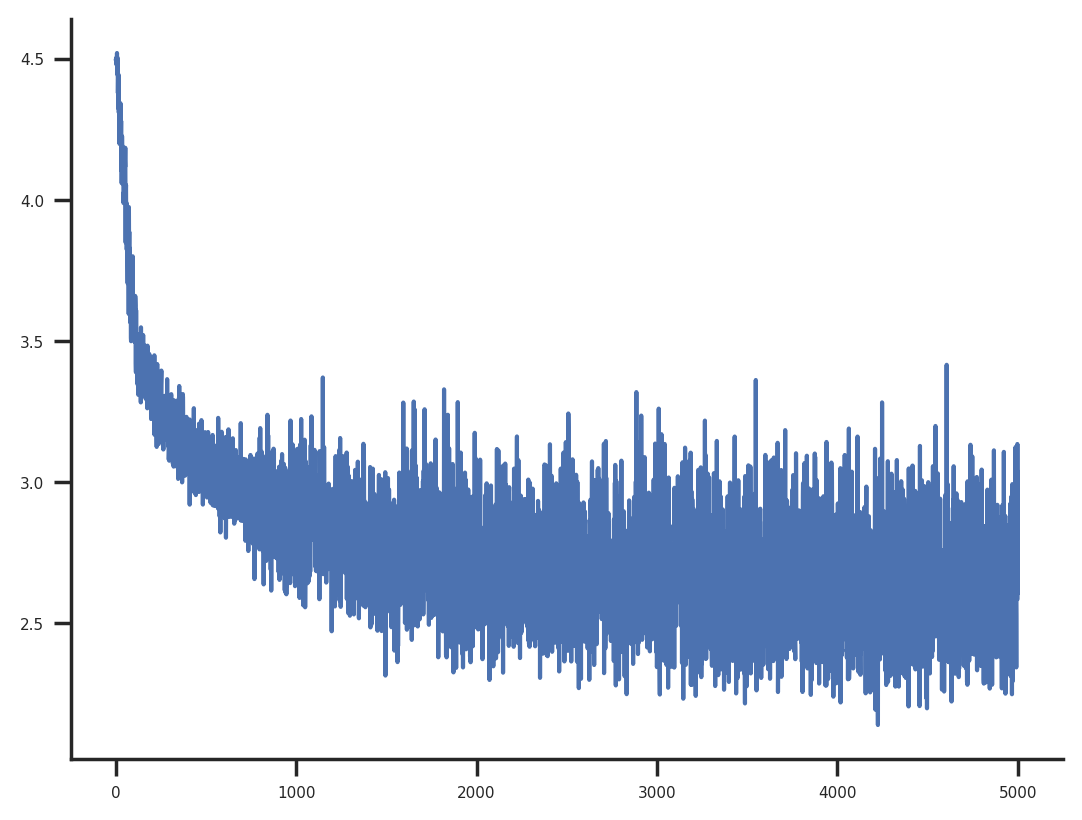

In [135]:
# Mode 1, self edges, 100 input genes
val_acc, loss_list = training_loop(model_self_concrete, data_self_concrete, 5000)
plt.plot(loss_list)

In [136]:
print(torch.max(F.softmax(model_self_concrete.concrete), axis=1))

torch.return_types.max(
values=tensor([0.0417, 0.0510, 0.0580, 0.0552, 0.0398, 0.0422, 0.0524, 0.0454, 0.0487,
        0.0489], grad_fn=<MaxBackward0>),
indices=tensor([ 5, 83, 83, 83,  5,  2, 83,  1,  2, 83]))


/tmp/ipykernel_366472/203247543.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.max(F.softmax(model_self_concrete.concrete), axis = 1))


Epoch: 200, Loss: 2.7043, Val acc: 0.4484
Epoch: 400, Loss: 1.8369, Val acc: 0.5868
Epoch: 600, Loss: 1.5907, Val acc: 0.6225
Epoch: 800, Loss: 1.4935, Val acc: 0.6706
Epoch: 1000, Loss: 1.5394, Val acc: 0.6084
Epoch: 1200, Loss: 1.2141, Val acc: 0.6961
Epoch: 1400, Loss: 1.2536, Val acc: 0.6593
Epoch: 1600, Loss: 1.1707, Val acc: 0.6901
Epoch: 1800, Loss: 1.2006, Val acc: 0.6923
Epoch: 2000, Loss: 1.1324, Val acc: 0.7080
Epoch: 2200, Loss: 1.0850, Val acc: 0.7004
Epoch: 2400, Loss: 1.0354, Val acc: 0.6988
Epoch: 2600, Loss: 0.9849, Val acc: 0.7236
Epoch: 2800, Loss: 1.0005, Val acc: 0.7231
Epoch: 3000, Loss: 0.9514, Val acc: 0.7296
Epoch: 3200, Loss: 0.9166, Val acc: 0.7117
Epoch: 3400, Loss: 1.0033, Val acc: 0.7447
Epoch: 3600, Loss: 0.9231, Val acc: 0.7647
Epoch: 3800, Loss: 0.9732, Val acc: 0.7280
Epoch: 4000, Loss: 0.9680, Val acc: 0.7382
Epoch: 4200, Loss: 0.8866, Val acc: 0.7469
Epoch: 4400, Loss: 0.9810, Val acc: 0.7539
Epoch: 4600, Loss: 0.9614, Val acc: 0.7545
Epoch: 4800, Lo

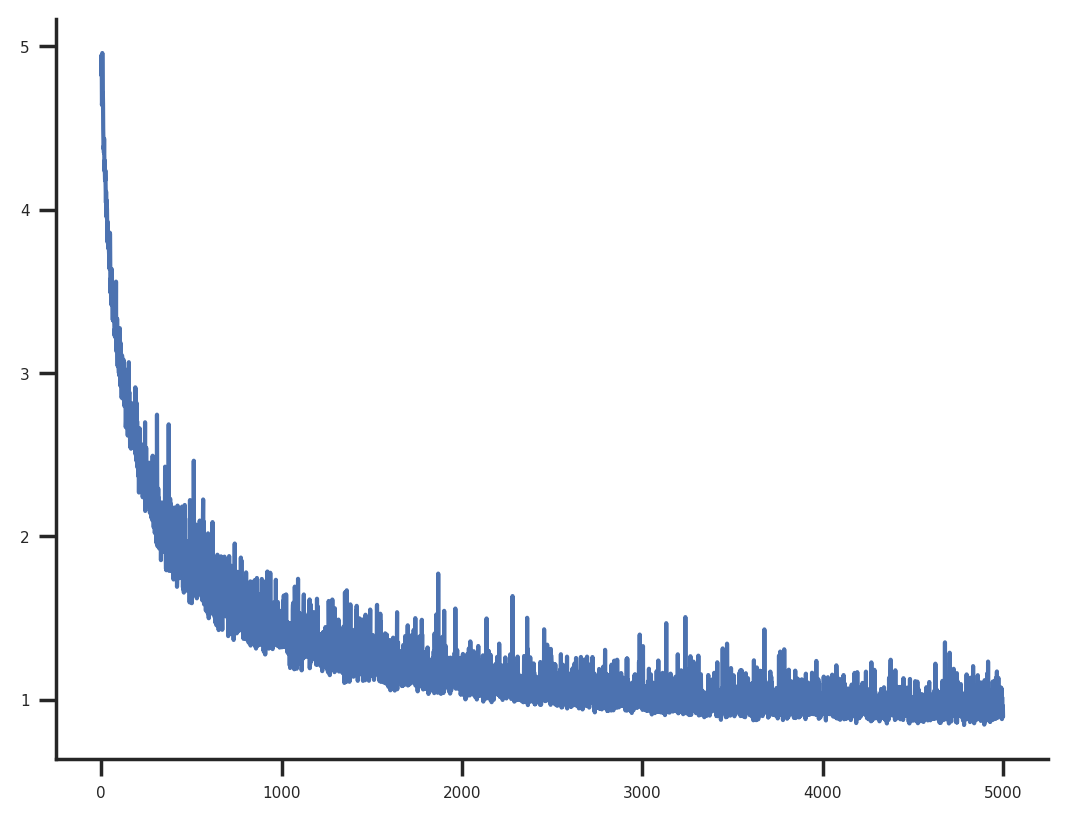

In [137]:
# Mode 2, self edges, 100 input genes (output not constrained with linear layer)
val_acc, loss_list_2 = training_loop(model_self_concrete_2, data_self_concrete, 5000)
plt.plot(loss_list_2)

In [138]:
print(
    torch.sum(torch.where(model_self_concrete_2.softmax()[:, 0] >= 0.9, 1.0, 0.0))
)  # 8 genes selected with high chance out of 100
print(torch.argwhere(model_self_concrete_2.softmax()[:, 0] >= 0.9))

tensor(36.)
tensor([[ 0],
        [ 1],
        [ 2],
        [ 4],
        [ 5],
        [ 6],
        [ 8],
        [10],
        [12],
        [17],
        [27],
        [29],
        [30],
        [31],
        [38],
        [45],
        [47],
        [49],
        [52],
        [56],
        [57],
        [59],
        [60],
        [63],
        [66],
        [69],
        [70],
        [72],
        [77],
        [80],
        [83],
        [84],
        [86],
        [87],
        [93],
        [99]])


Epoch: 200, Loss: 3.0655, Val acc: 0.2985
Epoch: 400, Loss: 2.7533, Val acc: 0.3705
Epoch: 600, Loss: 2.6248, Val acc: 0.4424
Epoch: 800, Loss: 2.6757, Val acc: 0.4830
Epoch: 1000, Loss: 2.6083, Val acc: 0.3743
Epoch: 1200, Loss: 2.4404, Val acc: 0.4478
Epoch: 1400, Loss: 2.4945, Val acc: 0.4592
Epoch: 1600, Loss: 2.4108, Val acc: 0.4613
Epoch: 1800, Loss: 2.4368, Val acc: 0.4867
Epoch: 2000, Loss: 2.3623, Val acc: 0.4873
Epoch: 2200, Loss: 2.3589, Val acc: 0.4819
Epoch: 2400, Loss: 2.3801, Val acc: 0.4884
Epoch: 2600, Loss: 2.3462, Val acc: 0.4824
Epoch: 2800, Loss: 2.4043, Val acc: 0.5024
Epoch: 3000, Loss: 2.3871, Val acc: 0.5014
Epoch: 3200, Loss: 2.4226, Val acc: 0.5095
Epoch: 3400, Loss: 2.3637, Val acc: 0.4905
Epoch: 3600, Loss: 2.4800, Val acc: 0.4965
Epoch: 3800, Loss: 2.3356, Val acc: 0.5024
Epoch: 4000, Loss: 2.3346, Val acc: 0.5041
Epoch: 4200, Loss: 2.3291, Val acc: 0.4694
Epoch: 4400, Loss: 2.3619, Val acc: 0.5014
Epoch: 4600, Loss: 2.4321, Val acc: 0.4727
Epoch: 4800, Lo

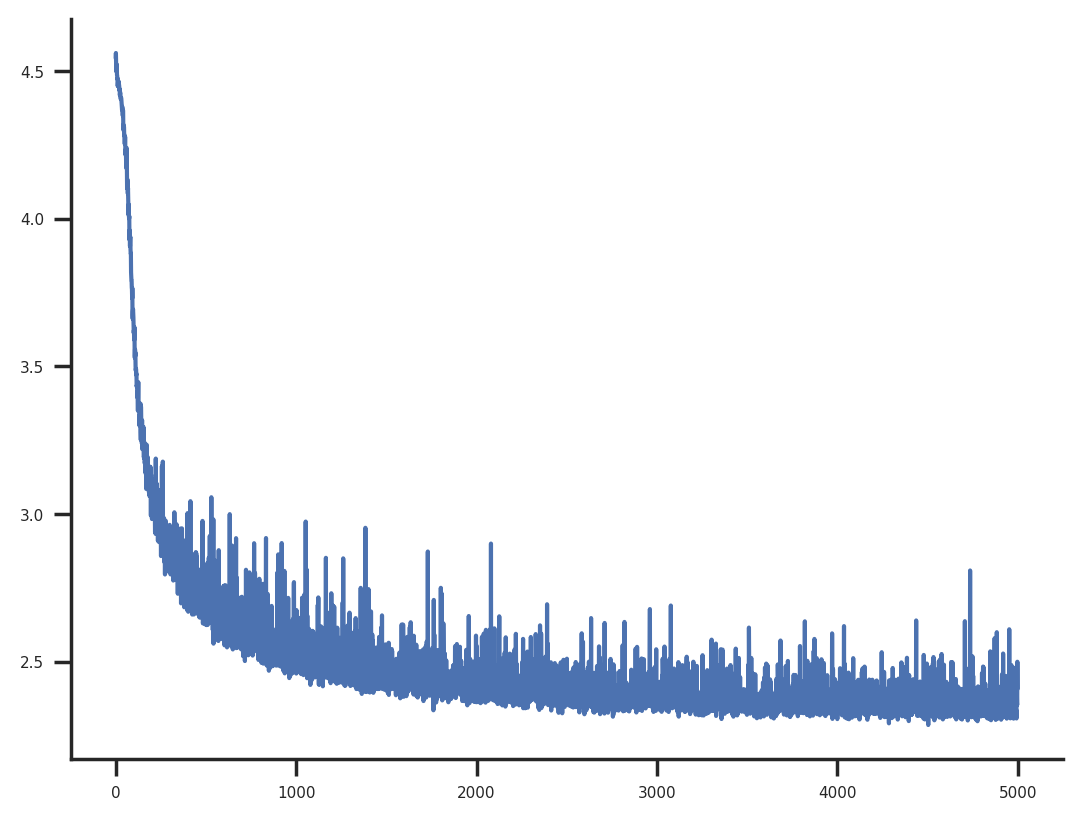

In [139]:
# Mode 2, self edges, 100 input genes, output constrained by linear layer
val_acc, loss_list_3 = training_loop(model_self_concrete_3, data_self_concrete, 5000)
plt.plot(loss_list_3)

In [140]:
torch.sum(
    torch.where(model_self_concrete_3.softmax()[:, 0] >= 0.9, 1.0, 0.0)
)  # 8 genes selected with high chance out of 100
print(torch.argwhere(model_self_concrete_3.softmax()[:, 0] >= 0.9))

tensor([[ 1],
        [ 5],
        [12],
        [30],
        [38],
        [59],
        [63],
        [69],
        [83],
        [84],
        [86],
        [93]])


Epoch: 200, Loss: 3.2831, Val acc: 0.1758
Epoch: 400, Loss: 3.2111, Val acc: 0.1909
Epoch: 600, Loss: 3.1557, Val acc: 0.2537
Epoch: 800, Loss: 3.0665, Val acc: 0.1590
Epoch: 1000, Loss: 2.9475, Val acc: 0.2893
Epoch: 1200, Loss: 2.9223, Val acc: 0.2450
Epoch: 1400, Loss: 2.9541, Val acc: 0.2888
Epoch: 1600, Loss: 2.9340, Val acc: 0.2553
Epoch: 1800, Loss: 2.9134, Val acc: 0.2434
Epoch: 2000, Loss: 2.8608, Val acc: 0.2888
Epoch: 2200, Loss: 3.0242, Val acc: 0.2207
Epoch: 2400, Loss: 2.6705, Val acc: 0.2720
Epoch: 2600, Loss: 2.8590, Val acc: 0.3050
Epoch: 2800, Loss: 2.9605, Val acc: 0.1931
Epoch: 3000, Loss: 2.8776, Val acc: 0.1747
Epoch: 3200, Loss: 2.8621, Val acc: 0.2818
Epoch: 3400, Loss: 3.2174, Val acc: 0.3029
Epoch: 3600, Loss: 2.8532, Val acc: 0.1747
Epoch: 3800, Loss: 3.0543, Val acc: 0.3294
Epoch: 4000, Loss: 2.9031, Val acc: 0.2726
Epoch: 4200, Loss: 2.7119, Val acc: 0.2553
Epoch: 4400, Loss: 2.9838, Val acc: 0.3526
Epoch: 4600, Loss: 2.7420, Val acc: 0.2985
Epoch: 4800, Lo

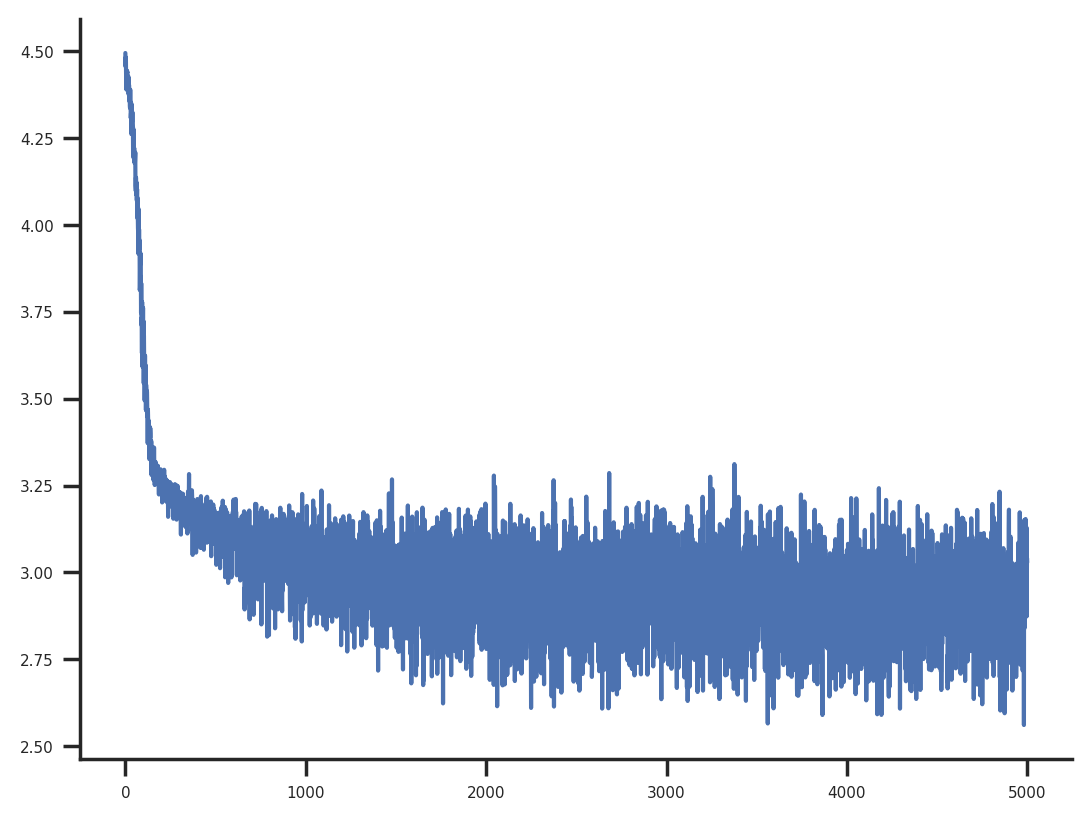

In [141]:
# Mode 1, self edges, full input genes
val_acc, loss_list_4 = training_loop(model_self_concrete_full, data_self_concrete_full, 5000)
plt.plot(loss_list_4)

In [142]:
print(torch.max(F.softmax(model_self_concrete_full.concrete), axis=1))

torch.return_types.max(
values=tensor([0.0074, 0.0040, 0.0104, 0.0056, 0.0111, 0.0109, 0.0029, 0.0034, 0.0038,
        0.0037], grad_fn=<MaxBackward0>),
indices=tensor([ 83,   1, 326,  21,  28, 324, 350, 331, 212, 267]))


/tmp/ipykernel_366472/674628426.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.max(F.softmax(model_self_concrete_full.concrete), axis = 1))


Epoch: 200, Loss: 3.1798, Val acc: 0.2774
Epoch: 400, Loss: 3.0507, Val acc: 0.1639
Epoch: 600, Loss: 3.0993, Val acc: 0.2818
Epoch: 800, Loss: 3.1238, Val acc: 0.3359
Epoch: 1000, Loss: 3.0890, Val acc: 0.3564
Epoch: 1200, Loss: 3.1459, Val acc: 0.2812
Epoch: 1400, Loss: 3.0086, Val acc: 0.2380
Epoch: 1600, Loss: 2.9055, Val acc: 0.2288
Epoch: 1800, Loss: 2.8224, Val acc: 0.3067
Epoch: 2000, Loss: 3.0162, Val acc: 0.2823
Epoch: 2200, Loss: 3.1184, Val acc: 0.1541
Epoch: 2400, Loss: 2.5459, Val acc: 0.3067
Epoch: 2600, Loss: 2.6505, Val acc: 0.3029
Epoch: 2800, Loss: 2.6979, Val acc: 0.1520
Epoch: 3000, Loss: 2.8512, Val acc: 0.2223
Epoch: 3200, Loss: 2.6509, Val acc: 0.3824
Epoch: 3400, Loss: 2.6662, Val acc: 0.3705
Epoch: 3600, Loss: 2.8236, Val acc: 0.4002
Epoch: 3800, Loss: 2.7671, Val acc: 0.3629
Epoch: 4000, Loss: 2.8877, Val acc: 0.3780
Epoch: 4200, Loss: 2.7088, Val acc: 0.3591
Epoch: 4400, Loss: 2.5239, Val acc: 0.3148
Epoch: 4600, Loss: 2.7510, Val acc: 0.3894
Epoch: 4800, Lo

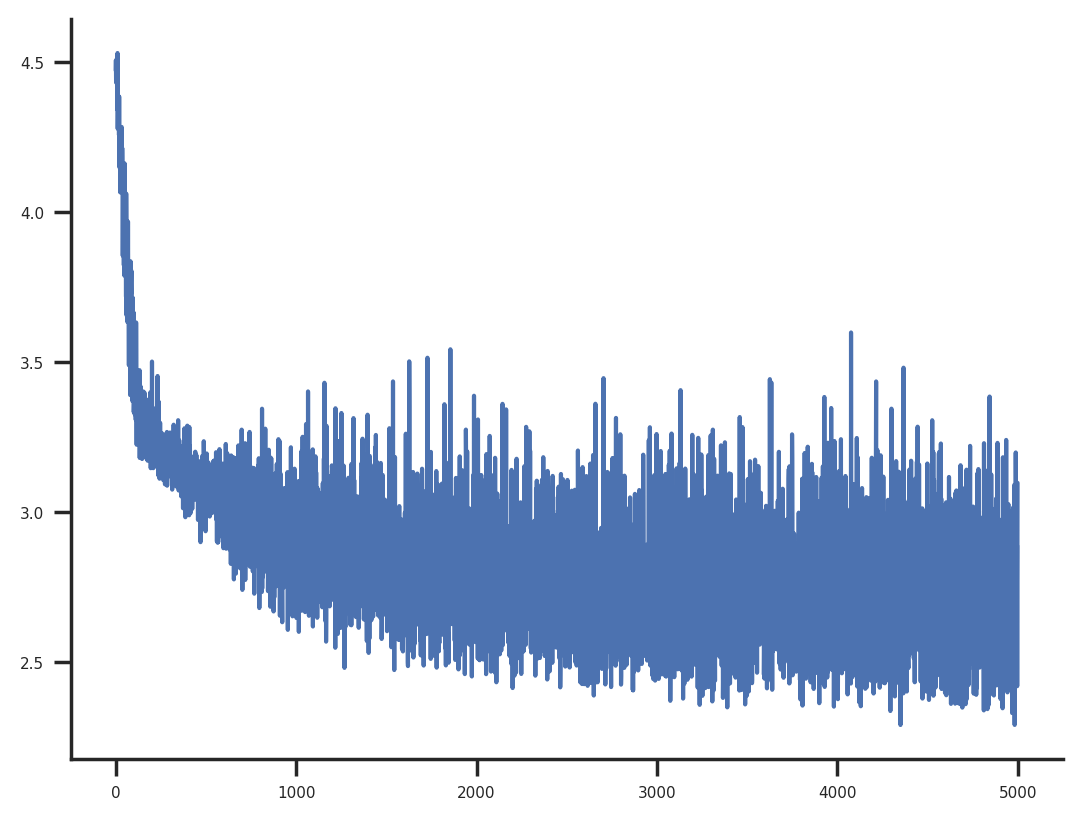

In [143]:
# Mode 1, knn edges, 100 input genes
val_acc, loss_list_5 = training_loop(model_knn_concrete, data_knn_concrete, 5000)
plt.plot(loss_list_5)

In [144]:
print(torch.max(F.softmax(model_knn_concrete.concrete), axis=1))

torch.return_types.max(
values=tensor([0.0388, 0.0487, 0.0370, 0.0306, 0.0444, 0.0459, 0.0724, 0.0515, 0.0540,
        0.0559], grad_fn=<MaxBackward0>),
indices=tensor([ 5,  2, 12, 83, 10,  2,  2,  2,  2,  2]))


/tmp/ipykernel_366472/1563201150.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.max(F.softmax(model_knn_concrete.concrete), axis = 1))
